In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys

if '..' not in sys.path:
    sys.path.append('..')

from data import ThreeBallsCollisionsFullSceneDataset

import torch
from torch.utils.data import DataLoader

import reservoirpy as rpy
from reservoirpy.nodes import Input, Reservoir, Ridge, ReLU, ESN
from reservoirpy.observables import mse

from itertools import product

from tqdm.notebook import tqdm_notebook

rpy.verbosity(0)
rpy.set_seed(42)

In [2]:
# Utility class for drawing the line with thickness from data space
# Source: https://stackoverflow.com/questions/19394505/expand-the-line-with-specified-width-in-data-unit/42972469#42972469

class data_linewidth_plot():
    def __init__(self, x, y, **kwargs):
        self.ax = kwargs.pop("ax", plt.gca())
        self.fig = self.ax.get_figure()
        self.lw_data = kwargs.pop("linewidth", 1)
        self.lw = 1
        self.fig.canvas.draw()

        self.ppd = 72./self.fig.dpi
        self.trans = self.ax.transData.transform
        self.linehandle, = self.ax.plot([],[],**kwargs)
        if "label" in kwargs: kwargs.pop("label")
        self.line, = self.ax.plot(x, y, **kwargs)
        self.line.set_color(self.linehandle.get_color())
        self._resize()
        self.cid = self.fig.canvas.mpl_connect('draw_event', self._resize)

    def _resize(self, event=None):
        lw =  ((self.trans((1, self.lw_data))-self.trans((0, 0)))*self.ppd)[1]
        if lw != self.lw:
            self.line.set_linewidth(lw)
            self.lw = lw
            self._redraw_later()

    def _redraw_later(self):
        self.timer = self.fig.canvas.new_timer(interval=10)
        self.timer.single_shot = True
        self.timer.add_callback(lambda : self.fig.canvas.draw_idle())
        self.timer.start()

In [3]:
def calculate_test_loss(model, dataloader, dataset, visualize_first_10_trajectories=True):
    test_loss = (np.sum(
        [mse(model.run(X.squeeze().numpy()), y.squeeze().numpy())*len(y) for X, y in tqdm_notebook(dataloader, desc='Loss calculation progress: ')]) / 
        len(dataset)) ** 0.5
    print('Test loss: ', test_loss)

    if visualize_first_10_trajectories:
        fig, axs = plt.subplots(10, 4, figsize=(20, 40))

        fig.suptitle('Trajectories of balls')
        plt.setp(axs[-1, :], xlabel='X-coordinate')
        plt.setp(axs[:, 0], ylabel='Y-coordinate')

        for row_id in range(len(axs)):
            axs[row_id, 0].set_xlim(0, 1)
            axs[row_id, 0].set_ylim(0, 1)
            axs[row_id, 1].set_xlim(0, 1)
            axs[row_id, 1].set_ylim(0, 1)
            axs[row_id, 2].set_xlim(0, 1)
            axs[row_id, 2].set_ylim(0, 1)
            axs[row_id, 3].set_xlim(0, 1)
            axs[row_id, 3].set_ylim(0, 1)

        for X, y in dataloader:
            pred = model.run(X.squeeze().numpy())

            for count in tqdm_notebook(range(10), desc='Plotting progress'):
                gr = np.insert(y.squeeze().numpy()[count].reshape(1,-1)[0], 0, X.squeeze().numpy()[count][[0, 1, 3, 4, 6, 7]])
                pr = np.insert(pred.squeeze()[count].reshape(1,-1)[0], 0, X.squeeze().numpy()[count][[0, 1, 3, 4, 6, 7]])

                axs[count, 0].plot(gr[0::6], gr[1::6], color='blue', label='Ground truth')
                axs[count, 0].plot(pr[0::6], pr[1::6], color='orange', label='Predicted')
                axs[count, 0].legend()

                axs[count, 1].plot(gr[2::6], gr[3::6], color='green', label='Ground truth')
                axs[count, 1].plot(pr[2::6], pr[3::6], color='orange', label='Predicted')
                axs[count, 1].legend()

                axs[count, 2].plot(gr[4::6], gr[5::6], color='red', label='Ground truth')
                axs[count, 2].plot(pr[4::6], pr[5::6], color='orange', label='Predicted')
                axs[count, 2].legend()

                data_linewidth_plot(pr[0::6], pr[1::6], ax=axs[count, 3], color='blue', linewidth=X.squeeze().numpy()[count][2], alpha=0.6)
                data_linewidth_plot(pr[2::6], pr[3::6], ax=axs[count, 3], color='green', linewidth=X.squeeze().numpy()[count][5], alpha=0.6)
                data_linewidth_plot(pr[4::6], pr[5::6], ax=axs[count, 3], color='red', linewidth=X.squeeze().numpy()[count][8], alpha=0.6)

            break

        plt.show()
    return test_loss

In [4]:
batch_size = 64

train_data, test_data = ThreeBallsCollisionsFullSceneDataset.train_test_split('../data/raw/three-balls-collisions-full-scene', test_frac=0.2, max_actions=100)

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size)

Test size:  1812
train_test_split response: test fraction rounded to 0.19995585963363496 (1812 simulations)


In [5]:
# Parameters for cross-validation hyperparameter turning

n_units = [150, 200, 250, 300, 500, 1000]
lrs = [0.9, 0.95]
srs = [0.01, 0.1, 0.3, 0.5]
ridges = [0.1, 0.3, 0.4]

In [6]:
# dictionary to store the results

import pickle

results = {}

results_file = 'results_dict_collisions_full_scene.pkl'

try:
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
except:
    results = {}

In [7]:
if results == {}:

    # Performing cross-validation hypterparameter turning

    results['simple_esn'] = []

    for units, lr, sr, ridge in tqdm_notebook(product(n_units, lrs, srs, ridges)):
        print(f'Testing units={units} \t lr={lr} \t sr={sr} \t ridge={ridge}')

        rpy.set_seed(42)

        reservoir1 = Reservoir(units=units, lr=lr, sr=sr, input_bias=False)
        readout1 = Ridge(output_dim=144, ridge=ridge) >> ReLU()

        model1 = reservoir1 >> readout1

        for X, y in train_dataloader:
            model1.fit(X.squeeze().numpy(), y.squeeze().numpy())

        test_loss = calculate_test_loss(model1, test_dataloader, test_data, visualize_first_10_trajectories=False)

        results['simple_esn'].append(
            {
                'units': units,
                'lr': lr,
                'sr': sr,
                'ridge': ridge,
                'test_loss': test_loss
            }
        )

        print()

        with open(results_file, 'wb') as f:
            pickle.dump(results, f)

Best result:  {'units': 150, 'lr': 0.95, 'sr': 0.01, 'ridge': 0.4, 'test_loss': 0.1587885585380937}


Training progress:   0%|          | 0/116 [00:00<?, ?it/s]

Loss calculation progress:   0%|          | 0/29 [00:00<?, ?it/s]

Test loss:  0.16067245814870768


Plotting progress:   0%|          | 0/10 [00:00<?, ?it/s]

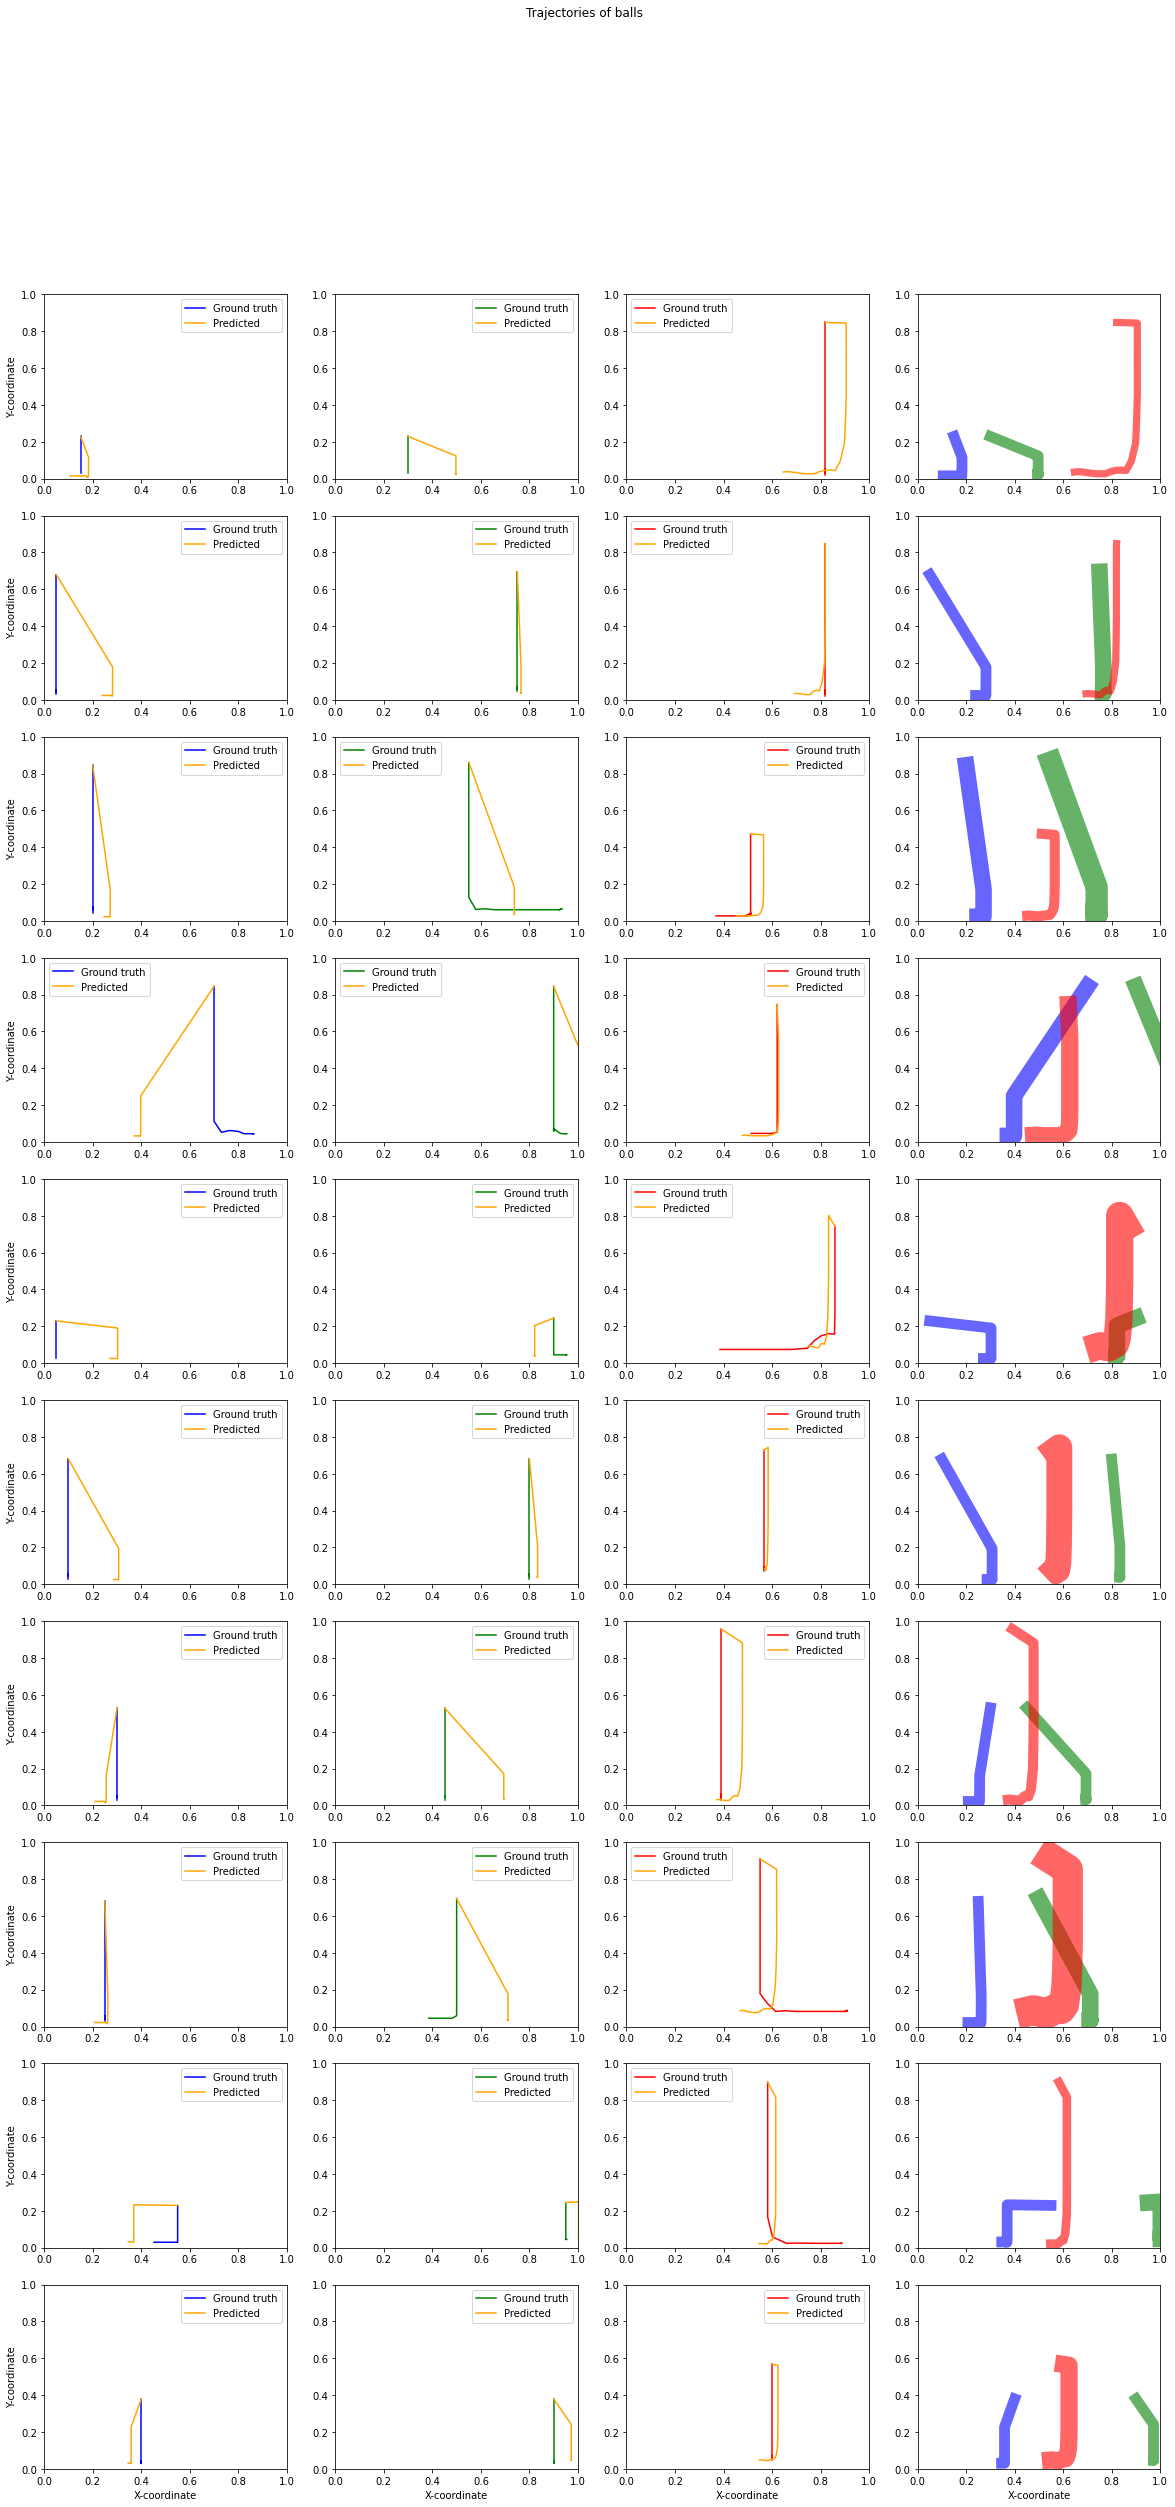

In [8]:
best_result = min(results['simple_esn'], key=lambda x: x['test_loss'])

print('Best result: ', best_result)

rpy.set_seed(42)

reservoir1 = Reservoir(units=best_result['units'], lr=best_result['lr'], sr=best_result['sr'], input_bias=False)
readout1 = Ridge(output_dim=144, ridge=best_result['ridge']) >> ReLU()

model1 = reservoir1 >> readout1

for X, y in tqdm_notebook(train_dataloader, desc='Training progress'):
    model1.fit(X.squeeze().numpy(), y.squeeze().numpy())

test_loss = calculate_test_loss(model1, test_dataloader, test_data, visualize_first_10_trajectories=True)